## Import modules

In [1]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import gc
import joblib # Use to save model
from datetime import datetime, timezone
# from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# from sklearn.model_selection import GridSearchCV
sns.set()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

## Load in features

In [3]:
ROOT  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_23T22_14_L001_r_0_1_grid_0_02_features.npz"""
ROOT_2  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_23T23_39_L001_r_0_2_grid_0_04_features.npz"""
ROOT_3  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_24T05_30_L001_r_0_4_grid_0_08_features.npz"""
ROOT_4  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_24T11_50_L001_r_0_8_grid_0_16_features.npz"""
ROOT_5  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_24T12_27_L001_r_1_6_grid_0_32_features.npz"""
ROOT_6 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_24T20_28_L001_r_3_2_grid_0_64_features.npz"""

In [4]:
ROOT_L002  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_11_05T15_44_L002_r_0_1_grid_0_02_features.npz"""
ROOT_L002_2  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_11_05T16_11_L002_r_0_2_grid_0_04_features.npz"""
ROOT_L002_3  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_11_06T01_27_L002_r_0_4_grid_0_08_features.npz"""
ROOT_L002_4  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_11_06T01_42_L002_r_0_8_grid_0_16_features.npz"""
ROOT_L002_5  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_11_06T01_54_L002_r_1_6_grid_0_32_features.npz"""
ROOT_L002_6 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_11_06T02_05_L002_r_3_2_grid_0_64_features.npz"""
# ROOT_7 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T00_29_L001_r_6_4_grid_1_28_features.npz"""
# ROOT_8 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T01_37_L001_r_12_8_grid_2_56_features.npz"""


In [5]:
fileList = [ROOT,ROOT_2, ROOT_3,ROOT_4,ROOT_5, ROOT_6]

In [6]:
fileList_L002 = [ROOT_L002, ROOT_L002_2,ROOT_L002_3,ROOT_L002_4,ROOT_L002_5,ROOT_L002_6]

## Get computed features

In [7]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

In [8]:
das2 = [np.load(r)["array2"] for r in fileList_L002]
das2 = np.hstack(das2)

xyz2 = np.load(fileList_L002[0])["array1"]

cls2 = np.load(fileList_L002[0])["array3"]

In [9]:
xyz.shape

(21567172, 3)

In [10]:
xyz = np.vstack((xyz, xyz2))
das = np.vstack((das, das2))
cls = np.concatenate((cls, cls2))

In [11]:
del das2, xyz2, cls2

## Load in points and labels

## Combine road markings with Ground points

In [12]:
# cls[cls==2] = 1

In [13]:
# cls[cls > 1] -= 1

## Get columns

In [14]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","count"]

In [15]:
# cols1 = [f"""{a}_radius1""" for a in cols]
# cols2 = [f"""{a}_radius2""" for a in cols]
ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
    

# allCols = cols1 + cols2
    
    
    

In [16]:
allCols = ['X', 'Y','Z'] + ff + ['label']

In [17]:
allAtrs = np.hstack((xyz,das, cls.reshape(-1, 1)))

In [18]:
del xyz, das, cls

## Create dataframe

In [19]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols)
total_dataframe["label"] = total_dataframe["label"].astype(int)
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype(int)
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [20]:
gc.collect()

176

In [21]:
# ss = ss[ss["count"] > 10]

## Create PLY files with features (Only do if they don't already exist)

In [22]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L002_features_radius{i}.ply""")

In [23]:
total_dataframe = total_dataframe.query("label != 0") # We are not going to train on unclassified points
total_dataframe = total_dataframe.copy()

## Load Random Forest classifier

In [24]:
gc.collect()

0

In [25]:
total_dataframe.groupby("label").size() / total_dataframe.shape[0]

label
1    0.557989
2    0.021970
3    0.106557
4    0.221473
5    0.009603
6    0.013401
7    0.065613
8    0.003393
dtype: float64

In [26]:
rf = RandomForestClassifier(verbose=1, n_jobs=8)

In [27]:
total_dataframe.reset_index(inplace = True)

In [28]:
gc.collect()

0

In [29]:
maxAcc = 0.0

AccList = []

F1_ScoreList = []

AccDelta = 1e-4

difDelta = np.inf

# f1_score(y_true, y_pred, average='weighted')


randomState = 123
sampleSize = 2000

iters = 0


idsTrained = []

RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,9):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = RemainTest.loc[RemainTest["label"] == i]
        SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = RemainTest[ff]
    RemainTestY = RemainTest["label"]
    
    RemainTest = RemainTest.loc[~RemainTest["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = RemainTest.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)
    f1 = f1_score(RemainTestSampleY, yPredSample,average = "weighted")

    difDelta = np.abs(maxAcc - f1)

    print("""\n\nCurrent f1 score: %.5f""" % f1)

    print("""\n\nCurrent f1 score delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = f1
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   

    
    
    
    
    # print(total_dataframe.loc[total_dataframe["label"] == i].shape[0])

Starting iteration 1...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.3s finished


Current accuracy: 82.6231


Current f1 score: 0.86750


Current f1 score delta: 0.86750
Starting iteration 2...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.4s finished


Current accuracy: 84.5654


Current f1 score: 0.88183


Current f1 score delta: 0.01433
Starting iteration 3...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.1s finished


Current accuracy: 85.8761


Current f1 score: 0.89143


Current f1 score delta: 0.02393
Starting iteration 4...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   11.9s finished


Current accuracy: 86.8438


Current f1 score: 0.89814


Current f1 score delta: 0.03064
Starting iteration 5...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.2s finished


Current accuracy: 87.5459


Current f1 score: 0.90307


Current f1 score delta: 0.00493
Starting iteration 6...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.8s finished


Current accuracy: 87.9708


Current f1 score: 0.90624


Current f1 score delta: 0.00811
Starting iteration 7...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   19.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.9s finished


Current accuracy: 88.5153


Current f1 score: 0.91010


Current f1 score delta: 0.01196
Starting iteration 8...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   33.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.3s finished


Current accuracy: 88.7798


Current f1 score: 0.91189


Current f1 score delta: 0.01375
Starting iteration 9...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   34.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.7s finished


Current accuracy: 89.2523


Current f1 score: 0.91530


Current f1 score delta: 0.01717
Starting iteration 10...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   30.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.3s finished


Current accuracy: 89.5447


Current f1 score: 0.91736


Current f1 score delta: 0.01922
Starting iteration 11...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   34.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.6s finished


Current accuracy: 89.8251


Current f1 score: 0.91932


Current f1 score delta: 0.02118
Starting iteration 12...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   38.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   13.8s finished


Current accuracy: 90.0837


Current f1 score: 0.92108


Current f1 score delta: 0.00177
Starting iteration 13...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   40.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.1s finished


Current accuracy: 90.2973


Current f1 score: 0.92261


Current f1 score delta: 0.00330
Starting iteration 14...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   43.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   34.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.3s finished


Current accuracy: 90.4875


Current f1 score: 0.92404


Current f1 score delta: 0.00473
Starting iteration 15...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   46.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   34.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.3s finished


Current accuracy: 90.7443


Current f1 score: 0.92584


Current f1 score delta: 0.00652
Starting iteration 16...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   20.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   52.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.4s finished


Current accuracy: 90.9616


Current f1 score: 0.92737


Current f1 score delta: 0.00806
Starting iteration 17...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   21.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   55.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.1s finished


Current accuracy: 91.1282


Current f1 score: 0.92864


Current f1 score delta: 0.00932
Starting iteration 18...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   21.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   59.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.6s finished


Current accuracy: 91.4192


Current f1 score: 0.93052


Current f1 score delta: 0.01121
Starting iteration 19...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.6s finished


Current accuracy: 91.5162


Current f1 score: 0.93134


Current f1 score delta: 0.01203
Starting iteration 20...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.4s finished


Current accuracy: 91.7083


Current f1 score: 0.93274


Current f1 score delta: 0.01343
Starting iteration 21...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   27.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.8s finished


Current accuracy: 91.7478


Current f1 score: 0.93300


Current f1 score delta: 0.01368
Starting iteration 22...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   14.8s finished


Current accuracy: 91.9196


Current f1 score: 0.93422


Current f1 score delta: 0.01491
Starting iteration 23...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.3s finished


Current accuracy: 92.1073


Current f1 score: 0.93555


Current f1 score delta: 0.01623
Starting iteration 24...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.3s finished


Current accuracy: 92.2254


Current f1 score: 0.93636


Current f1 score delta: 0.00081
Starting iteration 25...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   33.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.0s finished


Current accuracy: 92.3109


Current f1 score: 0.93697


Current f1 score delta: 0.00142
Starting iteration 26...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.4s finished


Current accuracy: 92.5315


Current f1 score: 0.93861


Current f1 score delta: 0.00306
Starting iteration 27...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.1s finished


Current accuracy: 92.6059


Current f1 score: 0.93908


Current f1 score delta: 0.00353
Starting iteration 28...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.3s finished


Current accuracy: 92.7426


Current f1 score: 0.94006


Current f1 score delta: 0.00451
Starting iteration 29...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.6s finished


Current accuracy: 92.8983


Current f1 score: 0.94118


Current f1 score delta: 0.00563
Starting iteration 30...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   43.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.8s finished


Current accuracy: 92.9467


Current f1 score: 0.94159


Current f1 score delta: 0.00605
Starting iteration 31...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   41.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.9s finished


Current accuracy: 92.9911


Current f1 score: 0.94184


Current f1 score delta: 0.00629
Starting iteration 32...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   42.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   40.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.7s finished


Current accuracy: 93.1168


Current f1 score: 0.94279


Current f1 score delta: 0.00724
Starting iteration 33...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   45.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.6s finished


Current accuracy: 93.1773


Current f1 score: 0.94317


Current f1 score delta: 0.00762
Starting iteration 34...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   49.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.4s finished


Current accuracy: 93.3738


Current f1 score: 0.94458


Current f1 score delta: 0.00903
Starting iteration 35...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   47.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.9s finished


Current accuracy: 93.4321


Current f1 score: 0.94502


Current f1 score delta: 0.00947
Starting iteration 36...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   50.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.9s finished


Current accuracy: 93.4878


Current f1 score: 0.94540


Current f1 score delta: 0.00985
Starting iteration 37...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   53.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.8s finished


Current accuracy: 93.5655


Current f1 score: 0.94598


Current f1 score delta: 0.01044
Starting iteration 38...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   55.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.2s finished


Current accuracy: 93.6484


Current f1 score: 0.94663


Current f1 score delta: 0.00065
Starting iteration 39...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   54.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   33.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.9s finished


Current accuracy: 93.6586


Current f1 score: 0.94667


Current f1 score delta: 0.00068
Starting iteration 40...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   59.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.0s finished


Current accuracy: 93.7681


Current f1 score: 0.94743


Current f1 score delta: 0.00145
Starting iteration 41...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   40.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.4s finished


Current accuracy: 93.8678


Current f1 score: 0.94819


Current f1 score delta: 0.00220
Starting iteration 42...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.1s finished


Current accuracy: 93.8807


Current f1 score: 0.94834


Current f1 score delta: 0.00236
Starting iteration 43...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.9s finished


Current accuracy: 93.9314


Current f1 score: 0.94871


Current f1 score delta: 0.00273
Starting iteration 44...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   40.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.2s finished


Current accuracy: 93.9816


Current f1 score: 0.94906


Current f1 score delta: 0.00307
Starting iteration 45...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.0s finished


Current accuracy: 94.0064


Current f1 score: 0.94920


Current f1 score delta: 0.00321
Starting iteration 46...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.9s finished


Current accuracy: 94.1213


Current f1 score: 0.95014


Current f1 score delta: 0.00415
Starting iteration 47...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.9s finished


Current accuracy: 94.1762


Current f1 score: 0.95054


Current f1 score delta: 0.00455
Starting iteration 48...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.5s finished


Current accuracy: 94.2068


Current f1 score: 0.95074


Current f1 score delta: 0.00476
Starting iteration 49...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   16.4s finished


Current accuracy: 94.2323


Current f1 score: 0.95089


Current f1 score delta: 0.00491
Starting iteration 50...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7
Label 8


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.5s finished


Current accuracy: 94.3121


Current f1 score: 0.95150


Current f1 score delta: 0.00551
DONE!!!!


In [30]:
gc.collect()

0

## Plot iterations and accuracy

In [35]:
# plot_df = pd.DataFrame(data = {"F1 Score" : F1_ScoreList, "Overall Accuracy" : AccList})

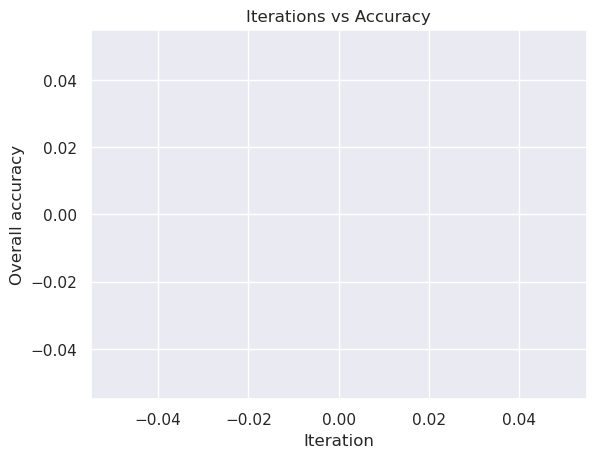

In [36]:
plt.plot(F1_ScoreList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [32]:
OUTS = f"""{datetime.now().strftime("%Y_%m_%d")}_Trained_radial_RF.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_11_08_Trained_radial_RF.joblib']